In [1]:
#!pip install fastai==0.7.0 --no-deps
#!pip install scikit-learn==0.21.3
# fastai depends also on an older version of torch
#!pip install torch==0.4.1 torchvision==0.1.9
#!pip install torchtext==0.2.3
#!pip show fastai

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [3]:
path = 'data/mnist/'
import os
os.makedirs(path, exist_ok=True)

In [4]:
URL='https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/' 
FILENAME='mnist.pkl.gz'
import gzip

    
def load_mnist(filename):
    print(filename)
    return pickle.load(gzip.open(filename), encoding='latin-1')

In [5]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

data/mnist/mnist.pkl.gz


In [6]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

## Normalize

In [7]:
mean = x.mean()
std = x.std()
x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

In [8]:
x_valid = (x_valid - mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

### Helper methods

In [9]:
def show(img, title=None):
    plt.imshow(img, cmap='gray');
    if title is not None: plt.title(title)

In [10]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

## Plots

In [12]:
x_valid.shape

(10000, 784)

In [13]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

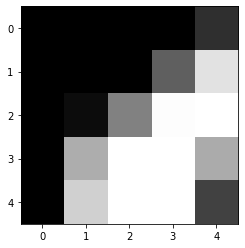

In [14]:
show(x_imgs[0,10:15,10:15])

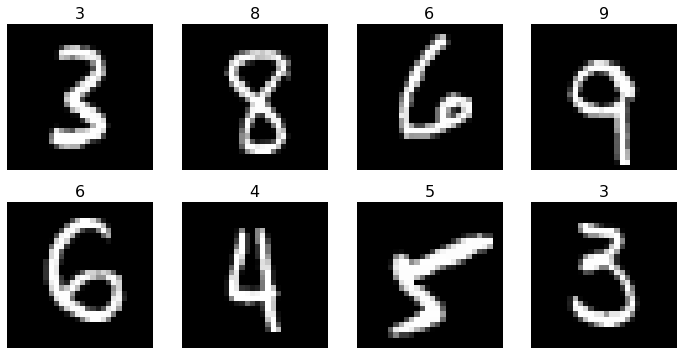

In [15]:
plots(x_imgs[:8], titles=y_valid[:8])

# Neural Net for Logistic Regression in PyTorch

In [16]:
from fastai.metrics import *


import torch.nn as nn

In [17]:
from fastai.model import *
from fastai.dataset import *

so this error is due to a bad python version, in 3.7 async is now a keyword..., need 3.6 python version to run this old fastai

In [54]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(), #acalled ctivation function, or a non-linear
    nn.Linear(100, 10),
    #to go deeper do that
    #nn.ReLU(),
    #nn.Linear(100, 10),
    nn.LogSoftmax()
).cuda()
#this is a two layer neural net
#.cuda tells to run on GPU, if didnt say that, would run on CPU

In [55]:
md = ImageClassifierData.from_arrays(path, (x, y), (x_valid, y_valid))

In [56]:
x.shape

(50000, 784)

In [57]:
loss = nn.NLLLoss() #negative low likelyhood loss = cross entropy. Either binary or categorical
metrics=[accuracy]
opt=optim.Adam(net.parameters())

### Fitting the model

In [58]:
fit(net, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics) #pythorch uses word "criterion" instead of loss

epoch      trn_loss   val_loss   accuracy                     
    0      0.191688   0.160782   0.9531    



[0.1607821581840515, 0.9531]

In [31]:
preds = predict(net, md.val_dl)
preds.shape

(10000, 10)

In [32]:
preds.argmax(axis=1)[:5] #argmax > figures out on this axis (for 10 in this case), return the index of the max value

array([3, 8, 6, 9, 6])

In [33]:
preds = preds.argmax(1) #saving this

In [34]:
np.mean(preds == y_valid)

0.9184

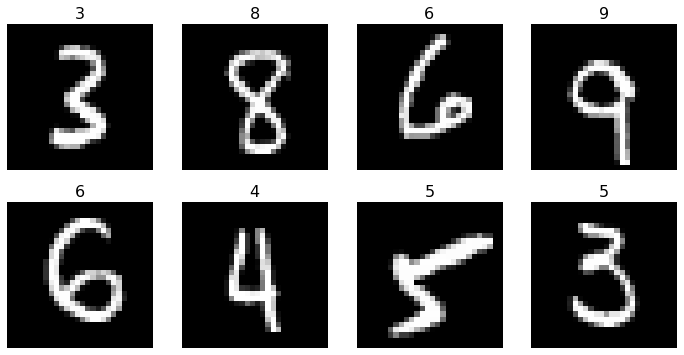

In [35]:
plots(x_imgs[:8], titles=preds[:8])

#we have just built a logistic regression, it is not a deep neural net yet

In [40]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0]) # because there are many layers, so need to make sure that the mean inputs not gonna change, otherwise its gonna diverge infinitely or converge it the number is bigger (gradient explosion)
#google: kaiming he initialization

In [41]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10) # Layer 1 weights
        self.l1_b = get_weights(10)   # Layer 1 bias
    def forward(self, x): #in pytorch it has special meaning, it will get called when the layer gets calculated, its gonna get passed data form previous layer
        x = x.view(x.size(0), -1) #view = reshape
        x = (x @ self.l1_w) +self.l1_b # Linear layer, @ is the matrix modification operator
        #activation function (softmax only one cat, if multiple - then use sigmoid), for nn to learn easier:
        x = torch.log(torch.exp(x)/(torch.exp(x).sum(dim=0))) #this is a softmax (because we want all probabiliteis of outcomes to sumup to 1), so it behaves so tthat it returns something that behaves as probabilities
        return x
#there is a lot of info on pytorch website on how to create tensors and modify stuff

In [42]:
#we define a * x, which are weights, then
#+b is called bias

In [43]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [44]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                    
    0      2.447005   2.405818   0.9068    



[2.405817628669739, 0.9068]

In [45]:
#1:19:30
np.sum(preds == y_valid)/len(preds)

0.9184

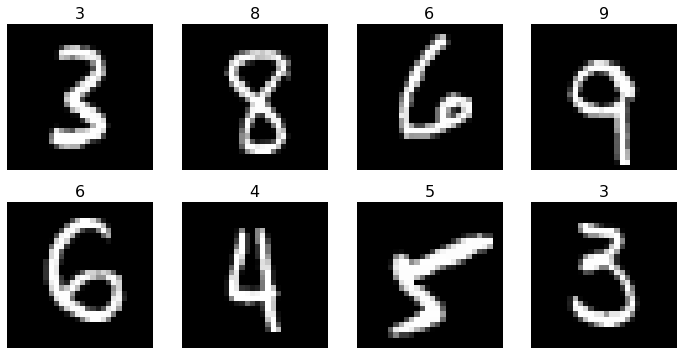

In [46]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [48]:
dl = iter(md.trn_dl)

In [49]:
xmb, ymb = next(dl)

In [50]:
vxmb = Variable(xmb.cuda())
vxmb

tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]],
       device='cuda:0')

In [53]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[4.2556e-05, 2.8079e-05, 4.3381e-06, 4.9543e-04, 4.8021e-03, 6.3931e-03,
         2.1820e-05, 7.3661e-02, 4.0192e-04, 3.8249e-02],
        [7.2391e-04, 4.8447e-04, 5.0316e-02, 2.9802e-02, 2.0140e-04, 4.2170e-03,
         1.4172e-05, 2.4045e-06, 9.6201e-04, 1.0274e-03],
        [1.3396e-03, 9.9111e-05, 8.0259e-04, 6.1613e-04, 1.6340e-03, 8.8616e-03,
         1.4998e-04, 9.7947e-02, 3.5790e-04, 4.6915e-02]],
       device='cuda:0', grad_fn=<SliceBackward>)